In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

In [2]:
df = pd.read_excel('/Volumes/Seagate Expansi/PhD Files/Data/AlbatrossOneData/06_2020/V3_F2.xlsx',sheet_name = 'DFDR_F2',
                  header=None)

In [3]:
df = df.fillna(method='ffill', axis=1)
df.head(5)

0                1             2                 3   \
0                Time             Time          Time              Time   
1  Master SW time (s)     VTP CAM time  VTP CAM time  Aircraft T/O (s)   
2               160.1  00:02:01.600000         121.6                 0   
3              160.12  00:02:01.620000         121.6                 0   
4              160.14  00:02:01.640000        121.62                 0   

         4         5         6         7         8         9   ...  \
0  SG Zerod  SG Zerod  SG Zerod  SG Zerod  SG Zerod  SG Zerod  ...   
1       SG1       SG2       SG3       SG4       SG5       SG6  ...   
2        -3        -2        -3         3         5         0  ...   
3         4        -2         0         9         6         0  ...   
4         1        -2        -2         1         3        -1  ...   

               84              85                 86                     87  \
0       ASpd(mph)       ASpd(m/s)            Cell(V)              eng1(mAh)   
1  Airspeed (mph)  Airspeed (m/s)  Right battery (V)  Engine 1 mAh consumed   
2               0               0              25.07                      4   
3               0               0              25.07                      4   
4               0               0              25.07                      4   

                      88                             89  \
0              eng2(mAh)                            Thr   
1  Engine 2 mAh consumed  Flaps full / take-off / clean   
2                     15                              3   
3                     15                              3   
4                     15                              3   

                                                 90      91         92  \
0                                                6P      SH  FWT Angle   
1  Tips Grd / H/L / H/L / Cruise / Cruise / Release  Brakes       Left   
2                                                 0       0    21.8292   
3                                                 0       0    21.8292   
4                                                 0       0    21.8292   

          93  
0  FWT Angle  
1      Right  
2    22.5674  
3    22.5674  
4    22.5674  

[5 rows x 94 columns]

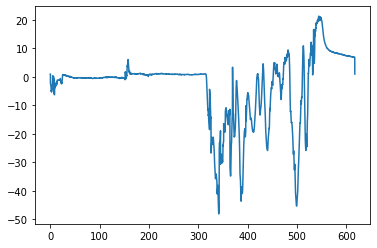

In [4]:
#plt.plot(df[0][2:]-df[0][2],df[55][2:])
plt.plot(df[0][2:]-df[0][2],df[57][2:])

In [17]:
def get_angle_data(filename,flip=False):
    df2 = pd.read_csv(filename)
    df2['t'] = df2['Frame']/df2['fps']
    df2['x_delta'] = df2['x0'] - df2['x1']
    df2['y_delta'] = df2['y0'] - df2['y1']
    df2['x_delta'] = df2['x_delta'].where((df2['x0']>df2['x1']).to_list(),df2['x1']-df2['x0'])
    df2['y_delta'] = df2['y_delta'].where((df2['x0']>df2['x1']).to_list(),df2['y1']-df2['y0'])
    df2['angle'] = np.rad2deg(np.arctan2(df2['y_delta'],df2['x_delta']))
    df2['angle'] = df2['angle'] if not flip else -df2['angle']
    return df2

In [18]:
df_left = get_angle_data('/Volumes/Seagate Expansi/PhD Files/Data/AlbatrossOneData/06_2020/FLT2_2_data_left.csv',False)
df_right = get_angle_data('/Volumes/Seagate Expansi/PhD Files/Data/AlbatrossOneData/06_2020/FLT2_2_data_right.csv',True) 

In [19]:
calib = get_angle_data('/Volumes/Seagate Expansi/PhD Files/Data/AlbatrossOneData/06_2020/calibpoints.csv')
calib['angle'] = calib['angle'].where(calib['wingtip']=='left',-calib['angle'])
flight = 2

left_x_c = calib[(calib['flight']==flight)&(calib['wingtip']=='left')]['angle']
left_y_c = calib[(calib['flight']==flight)&(calib['wingtip']=='left')]['angle_act']

right_x_c = calib[(calib['flight']==flight)&(calib['wingtip']=='right')]['angle']
right_y_c = calib[(calib['flight']==flight)&(calib['wingtip']=='right')]['angle_act']

df_left['angle_calib'] = np.interp(df_left['angle'],left_x_c,left_y_c)
df_right['angle_calib'] = np.interp(df_right['angle'],right_x_c,right_y_c)

# inital vlue for run 2 should be 22 degrees

df_left['angle_calib'] = df_left['angle_calib'] + (22-np.mean(df_left['angle_calib'][1:200]))
df_right['angle_calib'] = df_right['angle_calib'] + (22-np.mean(df_right['angle_calib'][1:200]))
                                         

In [37]:

delta = 315.2
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_left['t']+delta, y=df_left['angle_calib'],
                    mode='lines',
                    name='left'))
fig.add_trace(go.Scatter(x=df_right['t']+delta, y=df_right['angle_calib'],
                    mode='lines',
                    name='calib'))
# fig.add_trace(go.Scatter(x=df_right['t']+delta, y=-df_right['angle']+df_left['angle'],
#                     mode='lines',
#                     name='delta'))
fig.add_trace(go.Scatter(x=df[0][2:]-df[0][2], y=df[57][2:],
                    mode='lines',
                    name='roll'))
fig.add_trace(go.Scatter(x=df[0][2:]-df[0][2], y=df[55][2:]*25,
                    mode='lines',
                    name='status'))

fig.show()

In [38]:
df[92]=0
df[92][0]="FWT Angle"
df[92][1]="Left"
df[92][2:]=np.interp(df[0][2:]-df[0][2],df_left['t']+delta,df_left['angle_calib'])

df[93]=0
df[93][0]="FWT Angle"
df[93][1]="Right"
df[93][2:]=np.interp(df[0][2:]-df[0][2],df_right['t']+delta,df_right['angle_calib'])

/Users/fintan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/fintan/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/fintan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(-2, 6)

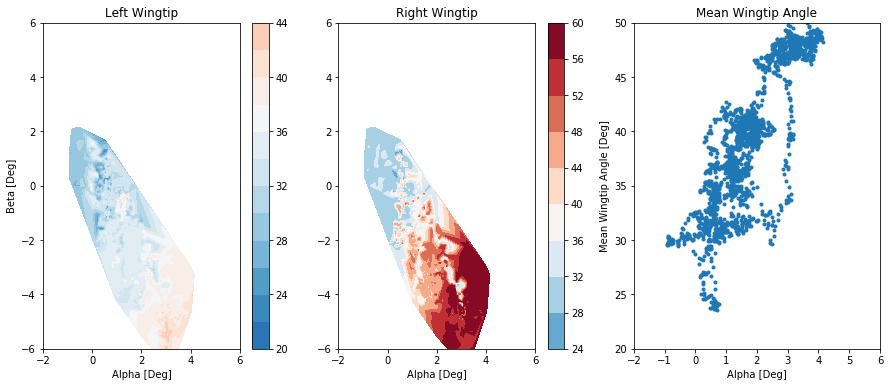

In [39]:
from scipy.interpolate import griddata
# alpha beta plot
release_df = df.copy()
release_df = release_df.drop([0,1])
release_df = release_df[((release_df[0]-df[0][2])>384) & ((release_df[0]-df[0][2])<424)]
alpha = release_df[52].to_list()
beta = release_df[53].to_list()
left_fwt = release_df[92].to_list()
right_fwt = release_df[93].to_list()
mean_fwt = [(left_fwt[i]+right_fwt[i])/2 for i in range(len(left_fwt))]

grid_x, grid_y = np.mgrid[min(alpha):max(alpha):100j, min(beta):max(beta):100j]

grid_left = griddata(list(zip(alpha,beta)), left_fwt, (grid_x, grid_y), method='linear')

plt.rcParams['figure.figsize'] = [15, 6]
plt.subplot('131')
plt.tricontourf(alpha, beta, left_fwt, levels=10, cmap="RdBu_r")
plt.colorbar()
plt.clim(15,60)
plt.ylim(-6,6)
plt.xlim(-2,6)
plt.xlabel('Alpha [Deg]')
plt.ylabel('Beta [Deg]')
plt.title('Left Wingtip')

plt.subplot('132')
plt.tricontourf(alpha, beta, right_fwt, levels=10, cmap="RdBu_r")
plt.colorbar()
plt.clim(15,60)
plt.ylim(-6,6)
plt.xlim(-2,6)
plt.xlabel('Alpha [Deg]')
plt.title('Right Wingtip')

plt.subplot('133')
plt.plot(alpha,mean_fwt,'.')
plt.xlabel('Alpha [Deg]')
plt.title('Mean Wingtip Angle')
plt.ylabel('Mean Wingtip Angle [Deg]')
plt.ylim(20,50)
plt.xlim(-2,6)

In [107]:
df[[92,93]].to_clipboard(sep=',', index=False)